In [52]:
from __future__ import division
import pandas as pd
import numpy as np 
import matplotlib.pylab as plt
from code.organize import *
from code.roughEDA import *
from code.survey_processor_full import *
from code.model_vis import *
from code.fc import *

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix,roc_curve
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.decomposition import PCA

from treeinterpreter import treeinterpreter as ti
import matplotlib.cm as cm
import cPickle as pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sv = survey('data/survey2/')

In [3]:
sv.num_processor()

In [4]:
df = sv.fin_data

In [6]:
dfc = df.copy()

y = dfc.pop('employed').values
X = dfc.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

In [7]:
rf = RandomForestClassifier(n_jobs=-1,random_state=0)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [8]:
f40 = rf.feature_importances_.argsort()[::-1][:40]
rf_redu = RandomForestClassifier(n_jobs=-1,random_state=0)
slct=dfc.columns[f40]   #selected features
X = dfc[slct].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=90)

In [9]:
rf_redu.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [22]:
#1st round
# rf_grid = {'max_depth': [3, None], 
#                       'max_features': ['sqrt', 'log2', None],
#                       'min_samples_split': [1, 2, 4],
#                       'min_samples_leaf': [1, 2, 4],
#                       'bootstrap': [True, False],
#                       'n_estimators': [10, 20, 40],
#                       'random_state': [1]}

# #2nd
# rf_grid = {'max_depth': [None], 
#            'criterion':['gini','entropy'],
#                       'max_features': ['log2', None],
#                       'min_samples_split': [1],
#                       'min_samples_leaf': [2],
#                       'bootstrap': [True, False],
#                       'n_estimators': [30, 40,80],
#                       'random_state': [1]}

# #3rd 
# rf_grid = {'max_depth': [None], 
#            'criterion':['entropy'],
#                       'max_features': ['log2'],
#                       'min_samples_split': [1],
#                       'min_samples_leaf': [2],
#                       'bootstrap': [False],
#                       'n_estimators': [60,80,100],
#                       'random_state': [1]}
# #last round
rf_grid = {'max_depth': [None], 
           'criterion':['gini','entropy'],
                      'max_features': ['log2',None],
                      'min_samples_split': [1],
                      'min_samples_leaf': [2],
                      'bootstrap': [False],
                      'n_estimators': [230,250,300],
                      'random_state': [1]}

In [23]:
rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             rf_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')

In [24]:
rf_gridsearch.fit(X_train,y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   54.6s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [230, 250, 300], 'min_samples_split': [1], 'random_state': [1], 'criterion': ['gini', 'entropy'], 'max_features': ['log2', None], 'bootstrap': [False], 'max_depth': [None], 'min_samples_leaf': [2]},
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc',
       verbose=True)

In [25]:
rf_gridsearch.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 1,
 'n_estimators': 300,
 'random_state': 1}

In [26]:
best_rf = rf_gridsearch.best_estimator_

roc_auc_score : 0.811187131244


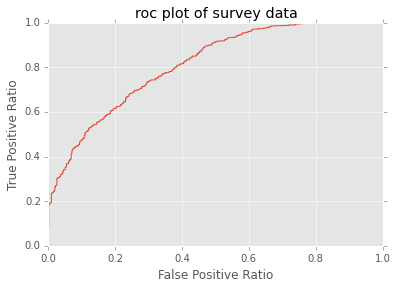

In [27]:
plot_roc(best_rf,X_test,y_test)

In [28]:
prediction, bias, contributions = ti.predict(best_rf, X)

In [30]:
fc_df = pd.DataFrame(contributions[:,:,1], columns=slct)

In [31]:
fc_df['predict'] = best_rf.predict(X)    # predicted result

In [32]:
fc_df['employed'] = y  

In [33]:
fc_df['correct'] = fc_df.predict == fc_df.employed 

In [34]:
fc_df.drop('predict',axis =1, inplace=True)   


In [35]:
fc_f_pca = fc_df.drop(['employed','correct'],axis =1)     

In [36]:
pca = PCA(n_components= 10)
pca.fit(fc_f_pca.values)

PCA(copy=True, n_components=10, whiten=False)

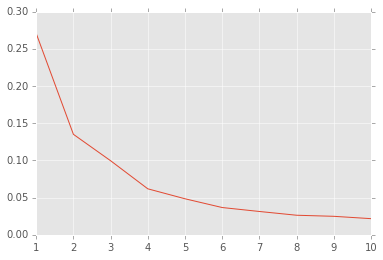

In [37]:
plt.plot(range(1,11),pca.explained_variance_ratio_)

In [157]:
pca = PCA(n_components=3)
fc_pca = pca.fit_transform(fc_f_pca.values)

4 clusters
         employed   correct
cluster                    
0        0.023209  0.982846
1        0.923353  0.923353
2        0.348921  0.910072
3        0.861071  0.878437
---
4 out of 4 clusters split the target ideally. Good cluster rate: 1.0
********************
5 clusters
         employed   correct
cluster                    
0        0.921053  0.920591
1        0.022222  0.983838
2        0.081744  0.929155
3        0.863173  0.880640
4        0.895753  0.899614
---
5 out of 5 clusters split the target ideally. Good cluster rate: 1.0
********************
6 clusters
         employed   correct
cluster                    
0        0.924484  0.924484
1        0.082192  0.928767
2        0.040498  0.975078
3        0.900459  0.901991
4        0.895753  0.899614
5        0.059809  0.930622
---
6 out of 6 clusters split the target ideally. Good cluster rate: 1.0
********************
7 clusters
         employed   correct
cluster                    
0        0.919614  0.919614
1 

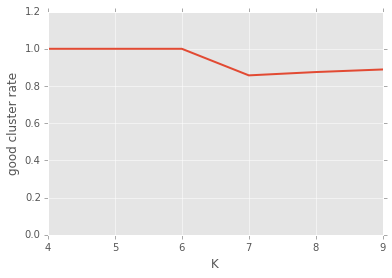

In [158]:
km_emp_mean(fc_pca,10,fc_df.employed,fc_df.correct)

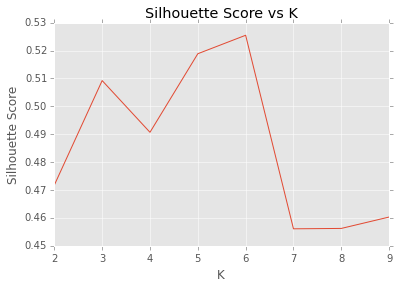

In [184]:
plot_silhouette(fc_pca,10)

('For n_clusters =', 6, 'The average silhouette_score is :', 0.52546132160706249)


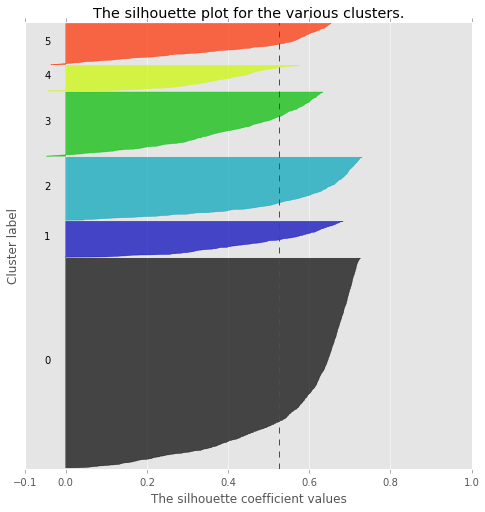

In [159]:
cluster_plot(fc_pca,6)

In [171]:
km = KMeans(n_clusters=6,random_state=0)
km.fit(fc_pca)
fc_df['cluster'] = km.labels_

In [172]:
summary = fc_df.groupby('cluster')['employed'].agg([np.mean,np.size])
summary.columns = ['employment_rate','sample_size']
summary

,employment_rate,sample_size
cluster,,
0,0.924484,2132
1,0.082192,365
2,0.040498,642
3,0.900459,653
4,0.895753,259
5,0.059809,418


In [173]:
df = pd.concat([sv.fin_data[sv.num_cols],sv.data[sv.sv_cols],sv.fin_data.employed],axis =1)

f31 = fc_df.columns[:41]
df31= df[f31]
l = list(df31.columns)
l.append('cluster')

new = np.column_stack((df31.values,fc_df.cluster))
df = pd.DataFrame(new,columns=l)

In [174]:
df[sv.num_cols] = df[sv.num_cols].astype('float')
df_num = df.groupby('cluster')[sv.num_cols].agg([np.median])

In [175]:
df_num

,sphrs1,age,agekdbrn,chldidel,coninc,educom
,median,median,median,median,median,median
cluster,,,,,,
0,60.0,36,25,4.0,49882.50,12.333333
1,98.0,31,19,5.0,8617.50,12.000000
2,54.5,35,25,8.0,52811.00,12.666667
3,98.0,33,21,4.0,9033.75,12.333333
4,98.0,34,19,4.0,18745.00,11.666667
5,98.0,34,22,6.5,7124.00,12.333333


In [176]:
# bs_dict = {k:v for (k,v) in zip(sv.bs_flag,sv.bs)}
# df_num.iloc[0:3,0] = bs_dict[98]
# df_num.iloc[4,0] = bs_dict[98]
# df_num.iloc[1,3] = bs_dict[8]
# df_num.iloc[5,3] = bs_dict[8]

In [177]:
cat_cols = list(set(df.columns) - set(sv.num_cols) - set(['cluster']))

In [178]:
df_cat = df.groupby('cluster')[cat_cols].agg([mode_answer,percent])

In [211]:
df_cat = df.groupby('cluster')[cat_cols].agg([rank_1st,rank_2nd])

In [212]:
df_summary = pd.concat([df_num,df_cat],axis =1)

In [213]:
df_summary.iloc[:,:20].T

cluster                                       0                        1  \
sphrs1   median                              60                       98   
age      median                              36                       31   
agekdbrn median                              25                       19   
chldidel median                               4                        5   
coninc   median                         49882.5                   8617.5   
educom   median                         12.3333                       12   
affrmact rank_1st        (Not applicable, 0.43)   (Not applicable, 0.43)   
         rank_2nd  (Strongly oppose pref, 0.31)      (Oppose pref, 0.18)   
fechld   rank_1st        (Not applicable, 0.39)    (Not applicable, 0.4)   
         rank_2nd        (Strongly agree, 0.25)            (Agree, 0.23)   
helpnot  rank_1st        (Not applicable, 0.44)   (Not applicable, 0.37)   
         rank_2nd       (Agree with both, 0.25)  (Agree with both, 0.25)   
spanking rank_1st         (Not applicable, 0.4)   (Not applicable, 0.41)   
         rank_2nd                 (Agree, 0.26)            (Agree, 0.25)   
mobile16 rank_1st             (Same city, 0.38)        (Same city, 0.45)   
         rank_2nd       (Different state, 0.31)  (Different state, 0.33)   
natrace  rank_1st        (Not applicable, 0.53)   (Not applicable, 0.53)   
         rank_2nd           (About right, 0.17)       (Too little, 0.17)   
natspac  rank_1st        (Not applicable, 0.53)   (Not applicable, 0.53)   
         rank_2nd            (About right, 0.2)      (About right, 0.18)   

cluster                                       2                             3  \
sphrs1   median                            54.5                            98   
age      median                              35                            33   
agekdbrn median                              25                            21   
chldidel median                               8                             4   
coninc   median                           52811                       9033.75   
educom   median                         12.6667                       12.3333   
affrmact rank_1st        (Not applicable, 0.45)        (Not applicable, 0.42)   
         rank_2nd  (Strongly oppose pref, 0.31)  (Strongly oppose pref, 0.25)   
fechld   rank_1st        (Not applicable, 0.41)        (Not applicable, 0.38)   
         rank_2nd                 (Agree, 0.25)                 (Agree, 0.26)   
helpnot  rank_1st        (Not applicable, 0.43)        (Not applicable, 0.39)   
         rank_2nd       (Agree with both, 0.23)       (Agree with both, 0.24)   
spanking rank_1st        (Not applicable, 0.43)         (Not applicable, 0.4)   
         rank_2nd                 (Agree, 0.26)                 (Agree, 0.24)   
mobile16 rank_1st       (Different state, 0.36)             (Same city, 0.47)   
         rank_2nd             (Same city, 0.31)       (Different state, 0.26)   
natrace  rank_1st        (Not applicable, 0.53)        (Not applicable, 0.53)   
         rank_2nd            (About right, 0.2)           (About right, 0.18)   
natspac  rank_1st        (Not applicable, 0.53)        (Not applicable, 0.53)   
         rank_2nd            (About right, 0.2)              (Too much, 0.22)   

cluster                                       4                             5  
sphrs1   median                              98                            98  
age      median                              34                            34  
agekdbrn median                              19                            22  
chldidel median                               4                           6.5  
coninc   median                           18745                          7124  
educom   median                         11.6667                       12.3333  
affrmact rank_1st        (Not applicable, 0.46)        (Not applicable, 0.44)  
         rank_2nd  (Strongly oppose pref, 0.18)  (Strongly op

In [214]:
df_summary.iloc[:,20:].T

cluster                                       0                             1  \
dwelling rank_1st  (Detached 1-fam house, 0.67)  (Detached 1-fam house, 0.36)   
         rank_2nd        (Apartment house, 0.1)       (Apartment house, 0.18)   
reliten  rank_1st       (Not very strong, 0.38)       (Not very strong, 0.42)   
         rank_2nd                (Strong, 0.37)                (Strong, 0.26)   
res16    rank_1st         (Town lt 50000, 0.28)         (Town lt 50000, 0.35)   
         rank_2nd        (50000 to 250000, 0.2)        (City gt 250000, 0.21)   
natfare  rank_1st        (Not applicable, 0.53)        (Not applicable, 0.53)   
         rank_2nd              (Too much, 0.23)             (Too little, 0.2)   
divorce  rank_1st                    (No, 0.52)        (Not applicable, 0.61)   
         rank_2nd        (Not applicable, 0.33)                     (No, 0.3)   
divlaw   rank_1st         (Not applicable, 0.4)        (Not applicable, 0.41)   
         rank_2nd        (More difficult, 0.28)                (Easier, 0.34)   
fefam    rank_1st        (Not applicable, 0.39)         (Not applicable, 0.4)   
         rank_2nd              (Disagree, 0.29)              (Disagree, 0.22)   
socbar   rank_1st         (Not applicable, 0.4)        (Not applicable, 0.41)   
         rank_2nd                 (Never, 0.23)                 (Never, 0.38)   
partyid  rank_1st      (Not str democrat, 0.21)           (Independent, 0.39)   
         rank_2nd           (Independent, 0.17)      (Not str democrat, 0.16)   
employed rank_1st                  (True, 0.92)                 (False, 0.92)   
         rank_2nd                 (False, 0.08)                  (True, 0.08)   
finrela  rank_1st               (Average, 0.49)         (Below average, 0.38)   
         rank_2nd         (Below average, 0.18)               (Average, 0.31)   
meovrwrk rank_1st        (Not applicable, 0.53)        (Not applicable, 0.52)   
         rank_2nd                 (Agree, 0.18)                 (Agree, 0.18)   
helpoth  rank_1st        (Not applicable, 0.47)        (Not applicable, 0.41)   
         rank_2nd         (3rd important, 0.19)          (3rd important, 0.2)   
life     rank_1st        (Not applicable, 0.42)        (Not applicable, 0.39)   
         rank_2nd               (Routine, 0.28)               (Routine, 0.33)   
degree   rank_1st           (High school, 0.56)         (Lt high school, 1.0)   
         rank_2nd              (Bachelor, 0.21)                     not apply   
socfrend rank_1st         (Not applicable, 0.4)        (Not applicable, 0.41)   
         rank_2nd          (Once a month, 0.17)                 (Never, 0.16)   
fund     rank_1st              (Moderate, 0.41)              (Moderate, 0.43)   
         rank_2nd        (Fundamentalist, 0.31)        (Fundamentalist, 0.31)   
courts   rank_1st      (Not harsh enough, 0.66)      (Not harsh enough, 0.53)   
         rank_2nd        (Not applicable, 0.14)             (Too harsh, 0.19)   
workhard rank_1st        (Not applicable, 0.47)        (Not applicable, 0.41)   
         rank_2nd         (2nd important, 0.19)         (2nd important, 0.18)   
marital  rank_1st               (Married, 0.66)         (Never married, 0.45)   
         rank_2nd              (Divorced, 0.14)               (Married, 0.33)   
kidssol  rank_1st        (Not applicable, 0.47)        (Not applicable, 0.39)   
         rank_2nd       (Somewhat better, 0.18)           (Much better, 0.29)   
incom16  rank_1st        (Not applicable, 0.44)        (Not applicable, 0.47)   
         rank_2nd               (Average, 0.28)               (Average, 0.18)   
natsoc   rank_1st            (Too little, 0.61)            (Too little, 0.55)   
         rank_2nd           (About right, 0.25)            (About right, 0.3)   
class_   rank_1st          (Working class, 0.5)         (Working class, 0.44)   
         rank_2nd          (Middle class, 0.42)          (Middle class, 0.26)   
natroad  rank_1st           (Ab

In [186]:
c0 = fc_df[fc_df.cluster == 0]
sort_feature_means(c0,15)

[(0.042080973391574079, 'coninc'),
 (0.021046270006271194, 'degree'),
 (0.01324399045827203, 'age'),
 (0.010083204302881267, 'educom'),
 (0.0092835604906183634, 'agekdbrn'),
 (0.0076032508735443816, 'sphrs1'),
 (0.0065322028558504911, 'class_'),
 (0.0065133198555721722, 'polviews'),
 (0.0061523862357446696, 'partyid'),
 (0.0056848289513118048, 'finrela'),
 (0.0054441194423180917, 'incom16'),
 (0.0050882987989528108, 'res16'),
 (0.0047437676311511672, 'fefam'),
 (0.0045608343142763044, 'reliten'),
 (0.00453488772893384, 'socfrend')]

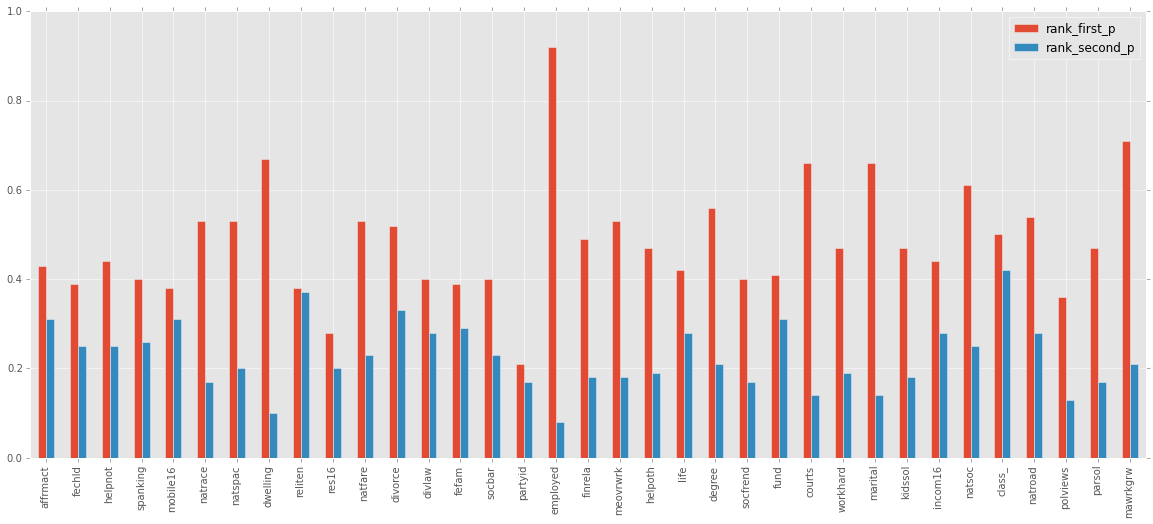

In [202]:
df_c0 = df[df.cluster ==0]
cluster_summary(df_c0,cat_cols).plot(kind = 'bar',figsize = (20,8))

In [203]:
cluster_summary(df_c0,cat_cols)

,rank_first_v,rank_first_p,rank_second_v,rank_second_p
affrmact,Not applicable,0.43,Strongly oppose pref,0.31
fechld,Not applicable,0.39,Strongly agree,0.25
helpnot,Not applicable,0.44,Agree with both,0.25
spanking,Not applicable,0.40,Agree,0.26
mobile16,Same city,0.38,Different state,0.31
natrace,Not applicable,0.53,About right,0.17
natspac,Not applicable,0.53,About right,0.20
dwelling,Detached 1-fam house,0.67,Apartment house,0.10
reliten,Not very strong,0.38,Strong,0.37
res16,Town lt 50000,0.28,50000 to 250000,0.20
